# Setup

## Import Relevant Modules

In our process, we will use the following Python modules:

* [Requests](https://docs.python-requests.org/en/master/): Used for submitting URL requests and interpreting responses therefrom
* [GeoPandas](https://geopandas.org/): A spatially-enabled flavor of the popular [Pandas](https://pandas.pydata.org/) module, which works with data in tabular `DataFrame` objects. GeoPandas adds the ability to interpret spatial data from ArcGIS Server REST endpoints, shapefiles, and many others, and can be used to export to many different spatial formats as well.
* [MatPlotLib](https://matplotlib.org/): A well-developed library of data visualization tools.


In [7]:
import requests
import geopandas as gp
import matplotlib.pyplot as plt

ImportError: DLL load failed while importing _datadir: The specified module could not be found.

In [5]:
sr = "{'wkid': 3435}"

In [26]:
parcels_url = 'https://maps.co.kendall.il.us/server/rest/services/Hosted/Current_Cadastral_Features/FeatureServer/1/query?'

## Construct Query

### PINs

Arguably the most important part of the query is specifying *which* parcels to run the tool for. This tool is written to work against a `.txt` file of PINs. Requests for farm cards often come in the form of 

In [3]:
with open('input_pins.txt', 'r') as file:
    pin_list = [pin.replace('-', '') for pin in file.read().split('\n')]

pin_list

['0735400005', '0736300004', '0736300006', '0736100001', '0735200005']

In [6]:
parcels_params = {
    'where': f"pin in ({','.join(pin_list)})",
    'outFields': 'gross_acres, pin',
    'outSR': sr,
    'f': 'geojson'
}

parcels = requests.get(parcels_url, parcels_params)

p_df = gp.read_file(parcels.text)

p_df['calc_area'] = p_df.area

p_df.head()

NameError: name 'requests' is not defined

In [42]:
bbox = f'{p_df.total_bounds[0]},{p_df.total_bounds[1]},{p_df.total_bounds[2]},{p_df.total_bounds[3]}'

In [43]:
bbox

'935547.6300369129,1745088.9799948186,940932.3499104939,1749073.1600185707'

In [52]:
soils_url = 'https://maps.co.kendall.il.us/server/rest/services/Hosted/Assessor_Soils/FeatureServer/0/query?'

lu_url = 'https://maps.co.kendall.il.us/server/rest/services/Hosted/Assessor_Landuse/FeatureServer/0/query?'

farm_params = {
    'where': '1=1',
    'outFields': '*',
    'returnGeometry': True,
    'geometryType': 'esriGeometryEnvelope',
    'geometry': bbox,
    'spatialRel': 'esriSpatialRelIntersects',
    'outSR': sr,
    'f': 'geojson'
}

soils = requests.get(soils_url, farm_params)
lu = requests.get(lu_url, farm_params)

In [53]:
s_df = gp.read_file(soils.text)

s_df.head()

,objectid,musym,globalid,soil_type,slope,SHAPE__Length,SHAPE__Area,geometry
0,394,145B,{2D794A20-B7EF-45FF-B655-F855FC78D003},145,B1,5383.604829,9.445314e+05,"POLYGON ((936003.251 1749618.066, 935921.164 1..."
1,1685,148A,{5EBBE6AD-7B76-4A12-A35C-D9F265C7EED9},148,A1,15587.239787,3.654991e+06,"POLYGON ((937346.980 1749254.753, 937291.739 1..."
2,1687,148A,{0B178009-AC76-4C21-9DE8-6EBC831ABFC7},148,A1,1937.991528,2.746759e+05,"POLYGON ((938637.996 1749031.941, 938688.959 1..."
3,1691,148A,{1133755D-D7B5-43DD-B8EA-DE8C741F2C79},148,A1,16601.097438,5.418792e+06,"POLYGON ((940237.499 1750323.332, 940178.465 1..."
4,1805,148B,{F4BF534B-E5FC-4DCA-A06B-852CB138650D},148,B1,7334.794554,9.237701e+05,"POLYGON ((934847.255 1745199.208, 934876.396 1..."


In [54]:
l_df = gp.read_file(lu.text)

l_df.head()

,objectid,landuse,globalid,landuse_type,SHAPE__Length,SHAPE__Area,geometry
0,1739,CR,{180B5AB0-6384-457A-A27B-600364F279D4},2,5471.262603,1.285937e+06,"POLYGON ((934712.266 1745074.442, 934958.210 1..."
1,1740,CR,{12ECCE76-2254-458E-91A3-0F546F3C27A3},2,1672.684633,8.767614e+04,"POLYGON ((935556.525 1747280.123, 935549.610 1..."
2,1741,CR,{79E92BF8-DF93-46E0-8951-28EFF402B7DB},2,13225.049770,6.456598e+06,"POLYGON ((943529.140 1746253.643, 943527.871 1..."
3,1742,CR,{6788F7F1-D79C-48A1-97E3-2EC676726216},2,9891.950064,4.907331e+06,"POLYGON ((939564.102 1747418.142, 939558.640 1..."
4,1743,CR,{4CF43653-D762-4AB6-8538-EEE9CE9AEDDA},2,2277.846824,1.612382e+05,"MULTIPOLYGON (((938512.191 1747711.903, 938233..."


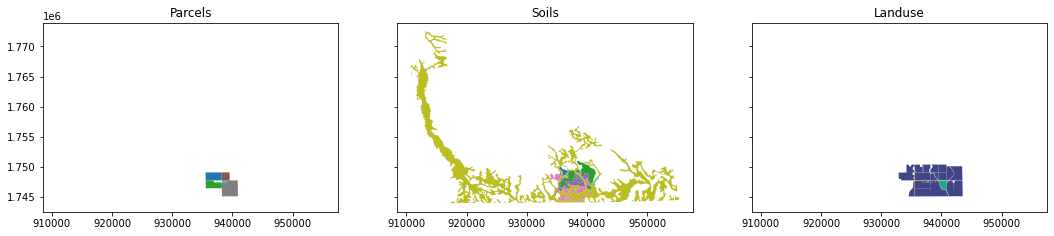

In [105]:
fig, axs = plt.subplots(1,3, figsize=(18,6), sharex=True, sharey=True)

p_df.plot(column='pin', ax=axs[0])
s_df.plot(column='musym', ax=axs[1])
l_df.plot(column='landuse_type', ax=axs[2])

axs[0].set_title('Parcels')
axs[1].set_title('Soils')
axs[2].set_title('Landuse')

plt.show()

In [226]:
df = gp.overlay(p_df, s_df, how='intersection')
df = gp.overlay(df, l_df, how='intersection')

df_keeps = [
    'gross_acres',
    'gis_acres',
    'calc_area',
    'pin',
    'soil_type',
    'slope',
    'landuse_type',
    'geometry'
]

for c in df:
    if c not in df_keeps:
        del df[c]

df.head()

,gross_acres,pin,calc_area,soil_type,slope,landuse_type,geometry
0,81.17,07-35-200-005,3.533025e+06,145,B1,2,"POLYGON ((936795.234 1749064.404, 936723.250 1..."
1,81.17,07-35-200-005,3.533025e+06,148,A1,2,"POLYGON ((936004.818 1747751.906, 936106.390 1..."
2,40.00,07-36-100-001,1.756259e+06,148,A1,2,"POLYGON ((938227.620 1748064.079, 938227.336 1..."
3,81.17,07-35-200-005,3.533025e+06,148,B1,2,"POLYGON ((935683.762 1747749.647, 935703.750 1..."
4,81.17,07-35-200-005,3.533025e+06,148,B1,2,"MULTIPOLYGON (((938227.336 1748064.200, 938232..."


<AxesSubplot:>

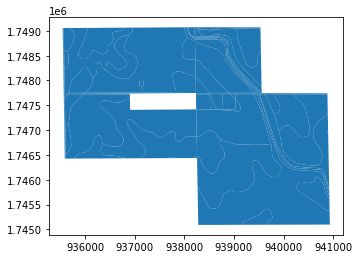

In [83]:
df.plot()

In [227]:
df = df.assign(part_acres=df['gross_acres'] / df['calc_area'] * df.area)
df.drop(['gross_acres', 'calc_area'], axis=1, inplace=True)

df.head()

,pin,soil_type,slope,landuse_type,geometry,part_acres
0,07-35-200-005,145,B1,2,"POLYGON ((936795.234 1749064.404, 936723.250 1...",7.179345
1,07-35-200-005,148,A1,6,"POLYGON ((936901.020 1747738.210, 936360.353 1...",0.304813
2,07-35-200-005,148,A1,6,"POLYGON ((937834.774 1747764.781, 937837.482 1...",0.122890
3,07-35-200-005,148,A1,6,"POLYGON ((937568.965 1747742.909, 936904.939 1...",0.305144
4,07-35-200-005,148,A1,6,"POLYGON ((936360.353 1747734.406, 936240.910 1...",0.000326


In [232]:
out_cols = ['pin', 'soil_type', 'slope', 'landuse_type']

# Dashes out of PIN
df['pin'] = df['pin'].str.replace('-', '')

# Prepend LU w/ 0
df['landuse_type'] = df['landuse_type'].astype('str')

# Sort values
df.sort_values(by=out_cols, ignore_index=True, inplace=True)

# Group identical columns, sum acreage
df = df.groupby(by=out_cols, as_index=False).sum()

# Round acreage
df['part_acres'] = round(df['part_acres'], 4)

# Drop rows w/ 0 acreage
df = df[df['part_acres'] > 0]

In [233]:
df.to_csv(f'./farm_output_{datetime.now().strftime("%Y%m%d")}.txt', sep='\t', header=False, index=False)